In [2]:
import os
import glob
import matplotlib               # type: ignore
import numpy             as np  # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.colors as mcolors
import platform
from   pathlib           import Path
import importlib
import readFiles
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import networkx as nx
importlib.reload(readFiles)

# Matplotlib rc parameters modification
plt.rcParams.update({
  "figure.max_open_warning" : 0,
  "text.usetex"             : True,
  "text.latex.preamble"     : r"\usepackage{amsmath, bm, type1cm}",  # Added \bm for bold math
  "figure.autolayout"       : True,
  "font.family"             : "STIXGeneral",
  "mathtext.fontset"        : "stix",
  "font.size"               : 8,
  "xtick.labelsize"         : 8,
  "ytick.labelsize"         : 8,
  "lines.linewidth"         : 1,
  "lines.markersize"        : 5,
})
#plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'

colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']


if platform.system() == 'Darwin':  # macOS
    topDir = Path("/Volumes/rahul_2TB/high_bidispersity/new_data/")
    fig_save_path = Path("/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/")
elif platform.system() == 'Linux':
    topDir = Path("/media/rahul/rahul_2TB/high_bidispersity/new_data/")
    fig_save_path = Path("/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/")
else:
    raise OSError("Unsupported OS")

In [13]:
## Angular velocity dumbell vs neighbouring k particle angular velocity
# Some simulation parameters

npp  = 1000
runs = 1
phi  = 0.72
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
k    = 7   # number of minimum values
phir = '{:.3f}'.format(phi) if len(str(phi).split('.')[1])>2 else '{:.2f}'.format(phi)

vt_dumbl_all = []
vt_neigh_all = []
colors_all   = []

for l in range(runs):
    # Paths
    dataname  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{l+1}"  
    dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
    parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
    intFile   = open(glob.glob(f'{dataname}/int_*.dat' )[0], 'r')
    rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')

    # Read data
    datdata   = np.genfromtxt(dataFile)
    pardata   = readFiles.readParFile(parFile)
    rigdata   = readFiles.rigList(rigFile)
    intdata   = readFiles.interactionsList(intFile)
    parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()
    totStrain = datdata[-1, 1]
    srate     = datdata[off:, 2]
    rigList   = [set(sum(rigFrame, [])) for rigFrame in rigdata] # flatten rig data

    # Box dimensions
    lx = float(parLines[3].split()[2]) 
    lz = float(parLines[5].split()[2])
    
    for t, intFrame in enumerate(intdata[off:]):
        sr = srate[t] # frame shear rate
        
        # All particle data
        parData = pardata[t]
        pidx    = parData[:, 0]
        px      = parData[:, 2]
        pz      = parData[:, 3]
        angvel  = parData[:, 8]
        vx      = parData[:, 4]
        vz      = parData[:, 6]
        vel_theta = np.arctan2(vz, vx)
        
        # Interacting particle data
        p1         = intFrame[:, 0]
        p2         = intFrame[:, 1]
        contState  = intFrame[:, 10]

        # Frictional interactions
        frictCont  = np.array(contState == 2, dtype = bool)
        p1_frict   = p1[frictCont]
        p2_frict   = p2[frictCont]
        pidx_frict = list(zip(p1_frict, p2_frict))
        
        # distance matrix
        xmat, zmat = np.outer(px, np.ones(len(px))), np.outer(pz, np.ones(len(pz))) # broadcasting position array
        dxij, dzij = xmat.transpose() - xmat, zmat.transpose() - zmat        # distance matrix
        
        # Lees Edwards boundary:
        dxij[dzij > lz/2.]  -= sr*lx
        dzij[dzij > lz/2.]  -= lz
        
        dxij[dzij < -lz/2.] += sr*lx
        dzij[dzij < -lz/2.] += lz
        
        # X peridodic:
        dxij[dxij >  lx/2.] -= lx
        dxij[dxij < -lx/2.] += lx
    
        dij   = np.sqrt(dxij**2 + dzij**2) # norm dist matrix
        color = np.array(['white'] * len(pidx_frict))

        for i, pair in enumerate(pidx_frict):
            p1, p2 = map(int, pair)
        
            # Neighbors of p1
            dists = dij[:, p1]
            idx1  = np.argsort(dists)
            mask  = dists[idx1] <= 1.5 * (1 + ar)
            n1    = idx1[mask][1:k+1]  # skip self
        
            # Neighbors of p2
            dists = dij[:, p2]
            idx2  = np.argsort(dists)
            mask  = dists[idx2] <= 1.5 * (1 + ar)
            n2    = idx2[mask][1:k+1]  # skip self
        
            # Filter out self and pair members
            n_all = np.concatenate((n1, n2))
            neigh = [x for x in n_all if x not in pair]
        
            vt_dumbl = np.mean([vel_theta[p1], vel_theta[p2]])
            vt_neigh = np.mean(vel_theta[neigh])
            
            vt_dumbl_all.append(vt_dumbl)
            vt_neigh_all.append(vt_neigh)
        
            if p1 in rigList[t] and p2 in rigList[t]:
                color[i] = 'red'
        
        colors_all.extend(list(color))
        
vt_dumbl_all = np.array(vt_dumbl_all) - np.mean(vt_dumbl_all)
vt_neigh_all = np.array(vt_neigh_all) - np.mean(vt_neigh_all)
colors_all   = np.array(colors_all)

In [14]:
vt_dumbl_all.shape

(2162892,)

0.72


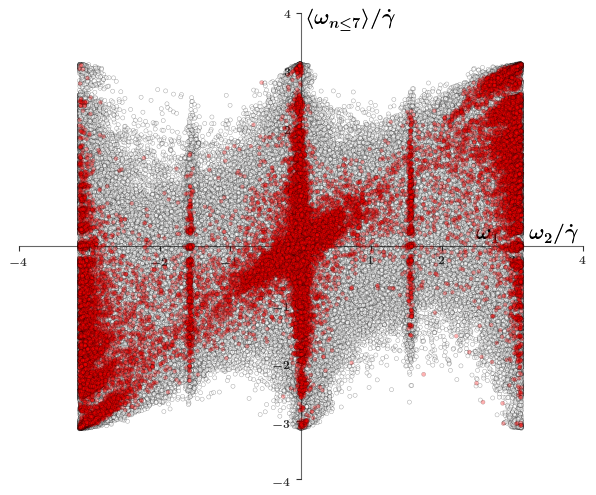

In [15]:
## plot w vs w_n=6 wrt to gamma
plt.figure(figsize = (6, 5))

is_red  = colors_all == 'red' # index of red points
not_red = ~is_red             # index of non-red points

plt.scatter(vt_dumbl_all[not_red], vt_neigh_all[not_red],      # non-red points below
            s=35, c=colors_all[not_red], alpha=0.4, marker='.',
            linewidths=0.3, edgecolors='k', zorder=1)

plt.scatter(vt_dumbl_all[is_red], vt_neigh_all[is_red],        # red points above
            s=35, c=colors_all[is_red], alpha=0.3, marker='.',
            linewidths=0.3, edgecolors='k', zorder=10)

ax = plt.gca()
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
    ax.spines[spine].set_alpha(0.6)
    
for spine in ['top', 'right']:
    ax.spines[spine].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xticks([t for t in ax.get_xticks() if t != 0])
ax.set_yticks([t for t in ax.get_yticks() if t != 0])
#ax.set_ylim(-30, 30) #angvel_neigh
#ax.set_xlim(-75, 75) #angvel

for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.tick1line.set_alpha(0.8)
    tick.label1.set_alpha(0.8)
ax.set_xlabel(r'$\omega_1 - \omega_2/ \dot \gamma$', labelpad=15, ha='right', fontsize=15)
ax.set_ylabel(fr'$\langle \omega_{{n \leq {k}}} \rangle / \dot \gamma$', labelpad=10, va='top', rotation=0, fontsize=15)
ax.xaxis.set_label_coords(0.99, 0.55)
ax.yaxis.set_label_coords(0.59, 1.01)
#plt.savefig(f"{fig_save_path}/angvel_{k}-neighbor_sr_rigid_phi_{phi}_ar_{ar}_vr_{vr}.png", bbox_inches="tight", dpi=800, transparent=False)
plt.grid(False)
print(f'{phi}')
plt.show()

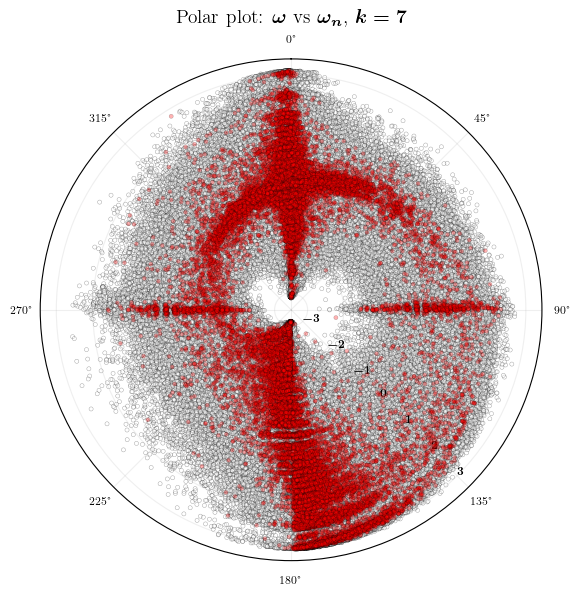

In [16]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# Plot non-red points
ax.scatter(vt_dumbl_all[not_red], vt_neigh_all[not_red],      # theta, r
           s=35, c=colors_all[not_red], alpha=0.4, marker='.',
           linewidths=0.3, edgecolors='k', zorder=1)

# Plot red points on top
ax.scatter(vt_dumbl_all[is_red], vt_neigh_all[is_red],
           s=35, c=colors_all[is_red], alpha=0.3, marker='.',
           linewidths=0.3, edgecolors='k', zorder=10)

# Customize polar plot
ax.set_theta_zero_location("N")   # zero at the top
ax.set_theta_direction(-1)        # clockwise

ax.set_rlabel_position(135)       # move radial labels
ax.grid(True, alpha=0.2)
ax.set_title(fr'Polar plot: $\omega$ vs $\omega_n$, $k={k}$', va='bottom', fontsize=14)

plt.show()

In [23]:
## Angular velocity vs RELEVANT neighbouring <=k particle angular velocity
# normalized wrt shear rate

npp  = 1000
runs = 1
phi  = 0.72
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
k    = 7  # max number of neighbors
phir = '{:.3f}'.format(phi) if len(str(phi).split('.')[1])>2 else '{:.2f}'.format(phi)

vnorm_all      = []
vorm_neigh_all = []

vtheta_all       = []
vtheta_neigh_all = []

colors_all = []
idxlen     = []

for l in range(runs):
    dataname  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{l+1}"  
    dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
    parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
    rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')
    datdata   = np.genfromtxt(dataFile)
    pardata   = readFiles.readParFile(parFile)
    rigdata   = readFiles.rigList(rigFile)
    srate     = datdata[off:, 2]
    totStrain = datdata[-1, 1]
    parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()

    lx = float(parLines[3].split()[2]) 
    lz = float(parLines[5].split()[2])
    
    for i, frame in enumerate(tqdm(pardata[off:], desc="Processing frames")):
        angvel = frame[:, 8]
        pidx   = frame[:, 0]
        pr     = frame[:, 1]
        px     = frame[:, 2]
        pz     = frame[:, 3]
        vx     = frame[:, 4]
        vz     = frame[:, 6]
        vnorm  = np.sqrt(vx**2 + vz**2)
        vtheta = np.arctan2(vz, vx)
        sr     = srate[i]
        
        xmat, zmat = np.outer(px, np.ones(len(px))), np.outer(pz, np.ones(len(pz))) # broadcasting position array
        dxij, dzij = xmat.transpose() - xmat, zmat.transpose() - zmat        # distance matrix
        
        # Lees Edwards boundary:
        dxij[dzij > lz/2.]  -= sr*lx
        dzij[dzij > lz/2.]  -= lz
        
        dxij[dzij < -lz/2.] += sr*lx
        dzij[dzij < -lz/2.] += lz
        
        # X peridodic:
        dxij[dxij >  lx/2.] -= lx
        dxij[dxij < -lx/2.] += lx
    
        dij     = np.sqrt(dxij**2 + dzij**2) # norm dist matrix
        color   = np.array(['white'] * npp)
        rigList = [set(sum(rigFrame, [])) for rigFrame in rigdata]
        
        for ii in pidx:
            sorted_indices = np.argsort(dij[:, int(ii)]) # all neighbors sorted by distance to particle ii
            within_cutoff  = dij[sorted_indices, int(ii)] <= 1.5 * (1+ar) # distance cuttoff
            idx = sorted_indices[within_cutoff][1:k+1]  # skip self # this list wont crash
            idxlen.append(len(idx))
            
            #vnorm_neigh = np.mean(vnorm[idx])     # mean ang vel of nearest neighbors
            #vorm_neigh_all.append(vnorm_neigh) 

            vtheta_neigh = np.mean(vtheta[idx])
            vtheta_neigh_all.append(vtheta_neigh)

        color[list(rigList[off+i])] = 'r'
        # vnorm_all.extend(vnorm)
        vtheta_all.extend(vtheta)
        colors_all.extend(list(color))

# vnorm_all      = np.array(vnorm_all) - np.mean(vnorm_all)
# vorm_neigh_all = np.array(vorm_neigh_all) - np.mean(vorm_neigh_all)

vtheta_all       = np.array(vtheta_all) - np.mean(vtheta_all)
vtheta_neigh_all = np.array(vtheta_neigh_all) - np.mean(vtheta_neigh_all)

colors_all     = np.array(colors_all)

Processing frames: 100%|████████████████████| 1901/1901 [03:46<00:00,  8.39it/s]


In [25]:
vtheta_all.shape

(1901000,)

In [19]:
colors_all     = np.array(colors_all)

0.72


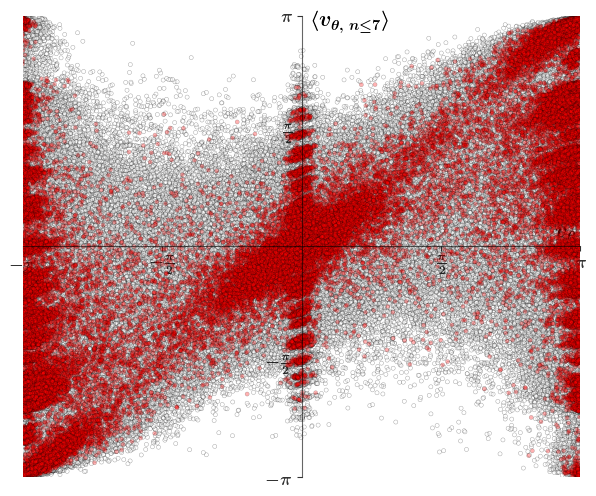

In [31]:
plt.figure(figsize=(6, 5))

# Identify red and non-red points
is_red  = colors_all == 'r'
not_red = ~is_red

# Scatter plot of non-red points
plt.scatter(vtheta_all[not_red], vtheta_neigh_all[not_red],
            s=35, c=colors_all[not_red], alpha=0.4, marker='.',
            linewidths=0.3, edgecolors='k', zorder=1)

# Scatter plot of red points
plt.scatter(vtheta_all[is_red], vtheta_neigh_all[is_red],
            s=35, c=colors_all[is_red], alpha=0.3, marker='.',
            linewidths=0.3, edgecolors='k', zorder=10)

# Get axis
ax = plt.gca()

# Position and style axes
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
    ax.spines[spine].set_alpha(0.6)
    ax.spines[spine].set_zorder(20)  # Bring spines to front

for spine in ['top', 'right']:
    ax.spines[spine].set_color('none')

# Tick placement
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Set axis limits from -π to π
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)

# π tick labels
pi_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
pi_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', 
             r'$\frac{\pi}{2}$', r'$\pi$']
ax.set_xticks(pi_ticks)
ax.set_xticklabels(pi_labels, fontsize=12)
ax.set_yticks(pi_ticks)
ax.set_yticklabels(pi_labels, fontsize=12)

# Style ticks
for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.tick1line.set_alpha(0.8)
    tick.label1.set_alpha(0.8)

ax.tick_params(zorder=20)  # Bring tick marks to front

# Axis labels
ax.set_xlabel(r'$v_\theta$', labelpad=15, ha='right', fontsize=15)
ax.set_ylabel(fr'$\langle v_{{\theta,\; n \leq {k}}} \rangle$', 
              labelpad=10, va='top', rotation=0, fontsize=15)
ax.xaxis.set_label_coords(0.99, 0.55)
ax.yaxis.set_label_coords(0.59, 1.01)

plt.grid(False)
print(f'{phi}')
plt.show()

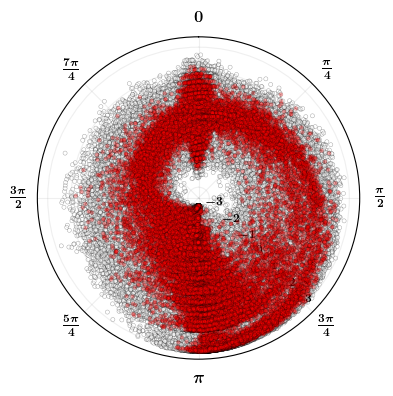

In [28]:
import numpy as np

plt.figure(figsize=(4, 4))
ax = plt.subplot(111, polar=True)

# Scatter points
ax.scatter(vtheta_all[not_red], vtheta_neigh_all[not_red],
           s=35, c=colors_all[not_red], alpha=0.4, marker='.',
           linewidths=0.3, edgecolors='k', zorder=1)

ax.scatter(vtheta_all[is_red], vtheta_neigh_all[is_red],
           s=35, c=colors_all[is_red], alpha=0.3, marker='.',
           linewidths=0.3, edgecolors='k', zorder=10)

# Customize polar plot
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlabel_position(135)
ax.grid(True, alpha=0.2)

# Set angular (theta) ticks in radians
angles_deg = np.arange(0, 360, 45)  # every 45°
angle_labels = [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',
                r'$\frac{3\pi}{4}$', r'$\pi$', r'$\frac{5\pi}{4}$',
                r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$']

ax.set_thetagrids(angles_deg, labels=angle_labels, fontsize=12)

#ax.set_title(fr'Polar plot: $\omega$ vs $\omega_n$, $k={k}$', va='bottom', fontsize=14)

plt.show()